# Perkenalan

Perkenalkan nama saya Wildan Abdurrasyid seorang Mahasiswa sem 3 Institut Teknologi Tangerang Selatan.

pada proyek ini saya akan membuat Model NLP (Natural Language processing) sederhana dari dataset yang telah saya dapatkan.

link source dataset: https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification

In [18]:
import pandas as pd
df = pd.read_csv('cyberbullying_tweets.csv')
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


## Text Cleaning

In [19]:
import re
import nltk
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
Stopwords = set(stopwords.words('english'))
def clean(text):
    text = text.lower() #Converting to lowerCase
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ',text) #removing punctuation

    text_tokens = word_tokenize(text) #removing stopwords
    tw = [word for word in text_tokens if not word in Stopwords]
    text = (" ").join(tw)

    splt = text.split(' ')
    output = [x for x in splt if len(x) > 3] #removing words with length<=3
    text = (" ").join(output)

    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text) #removing single character
    text = re.sub('<.*?>+',' ',text) #removing HTML Tags
    text = re.sub('\n', ' ',text) #removal of new line characters
    text = re.sub(r'\s+', ' ',text) #removal of multiple spaces
    return text

df['tweet_text'] = df['tweet_text'].apply(clean)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Preproses Data

In [20]:
nltk.download('wordnet')
def data_preprocessing(text):
    tokens = word_tokenize(text) #Tokenization
    tokens = [WordNetLemmatizer().lemmatize(word) for word in tokens] #Lemmetization
    tokens = [SnowballStemmer(language = 'english').stem(word) for word in tokens] #Stemming
    return " ".join(tokens)

df['tweet_text'] = df['tweet_text'].apply(data_preprocessing)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## one-hot-encoding dan membuat dataframe baru.

In [21]:
category = pd.get_dummies(df.cyberbullying_type)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='cyberbullying_type')
df_baru

,tweet_text,age,ethnicity,gender,not_cyberbullying,other_cyberbullying,religion
0,word katandandr food crapilici,0,0,0,1,0,0
1,aussietv white theblock imacelebrityau today s...,0,0,0,1,0,0
2,xochitlsuckkk classi whore velvet cupcak,0,0,0,1,0,0
3,jason thank head concern anoth angri dude twitter,0,0,0,1,0,0
4,rudhoeenglish isi account pretend kurdish acco...,0,0,0,1,0,0
...,...,...,...,...,...,...,...
47687,black expect anyth depend anyth free particip ...,0,1,0,0,0,0
47688,turner withhold disappoint turner call court a...,0,1,0,0,0,0
47689,swear dumb nigger bitch bleach hair reeeeeal f...,0,1,0,0,0,0
47690,fuck therealexel your nigger fuck unfollow fuc...,0,1,0,0,0,0


In [22]:
text_column = 'tweet_text'
genre_columns = ['age', 'ethnicity', 'gender', 'not_cyberbullying', 'other_cyberbullying', 'religion']
X = df_baru[text_column].values
Y = df_baru[genre_columns].values

## Pembagian Data Training dan Testing

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

##  Tokenisasi

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(x_train)

sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

padded_train = pad_sequences(sequences_train, padding='post', maxlen=100, truncating='post')
padded_test = pad_sequences(sequences_test, padding='post', maxlen=100, truncating='post')


## Modelling dan Compile

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, LSTM

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),  # Increased output_dim
    Bidirectional(LSTM(128, return_sequences=True)),  # Bidirectional LSTM
    Bidirectional(LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),  # Increased number of units
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(genre_columns), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


## Fungsi Callbacks

In [26]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.9 and logs.get('val_accuracy') > 0.9:
            print("\nAkurasi telah mencapai >90%!")
            self.model.stop_training = True

callbacks = myCallback()

## Latih Data dengan Callbacks

In [27]:
num_epochs = 10
history = model.fit(padded_train, y_train, epochs=num_epochs, validation_data=(padded_test, y_test), callbacks=[callbacks], verbose=2)

Epoch 1/10
1193/1193 - 587s - loss: 0.7143 - accuracy: 0.6771 - val_loss: 0.4790 - val_accuracy: 0.7813 - 587s/epoch - 492ms/step
Epoch 2/10
1193/1193 - 549s - loss: 0.4368 - accuracy: 0.8056 - val_loss: 0.4473 - val_accuracy: 0.8073 - 549s/epoch - 460ms/step
Epoch 3/10
1193/1193 - 547s - loss: 0.3809 - accuracy: 0.8444 - val_loss: 0.4355 - val_accuracy: 0.8251 - 547s/epoch - 458ms/step
Epoch 4/10
1193/1193 - 554s - loss: 0.3442 - accuracy: 0.8608 - val_loss: 0.4335 - val_accuracy: 0.8242 - 554s/epoch - 464ms/step
Epoch 5/10
1193/1193 - 548s - loss: 0.3156 - accuracy: 0.8736 - val_loss: 0.4308 - val_accuracy: 0.8223 - 548s/epoch - 460ms/step
Epoch 6/10
1193/1193 - 551s - loss: 0.2957 - accuracy: 0.8806 - val_loss: 0.4701 - val_accuracy: 0.8227 - 551s/epoch - 462ms/step
Epoch 7/10
1193/1193 - 552s - loss: 0.2755 - accuracy: 0.8868 - val_loss: 0.4884 - val_accuracy: 0.8195 - 552s/epoch - 463ms/step
Epoch 8/10
1193/1193 - 552s - loss: 0.2580 - accuracy: 0.8956 - val_loss: 0.4955 - val_acc

## Evaluate accuracy

In [28]:
train_accuracy = model.evaluate(padded_train, y_train, verbose=0)[1]
test_accuracy = model.evaluate(padded_test, y_test, verbose=0)[1]

print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Training Accuracy: 91.82%
Test Accuracy: 81.57%


## Plot loss and accuracy

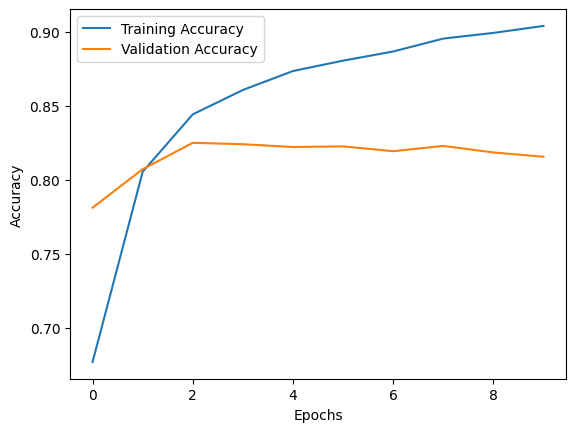

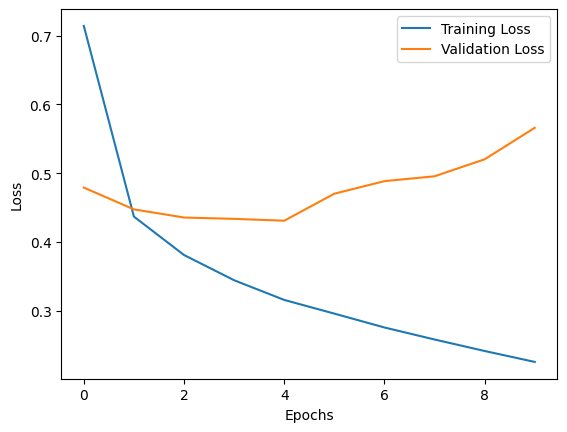

In [29]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()